In [55]:
# Upload Dataset File
from google.colab import files
uploaded = files.upload()

Saving IOT-temp-1.csv to IOT-temp-1.csv


In [77]:
# Import Library are required
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

data_train = pd.read_csv('IOT-temp-1.csv')
df_data_train = data_train.drop(columns=['id','room_id/id'])

In [78]:
df_data_train.tail()

,noted_date,temp,out/in
2994,29-11-2018 00:57,37,Out
2995,29-11-2018 00:47,36,Out
2996,29-11-2018 00:47,36,Out
2997,29-11-2018 00:41,37,Out
2998,29-11-2018 00:41,37,Out


In [79]:
# Checking missing file
data_train.isnull().sum()

id            0
room_id/id    0
noted_date    0
temp          0
out/in        0
dtype: int64

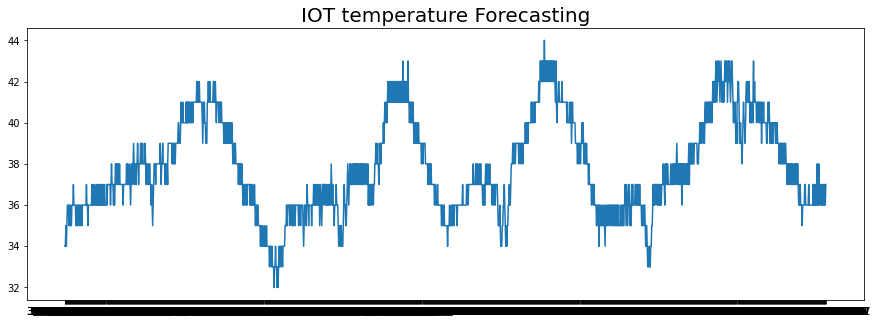

In [80]:
# Separate the atribute and labels
dates = data_train['noted_date'].values
temp  = data_train['temp'].values

plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('IOT temperature Forecasting',
          fontsize=20);

In [82]:
# Split the data using train_test_split
from sklearn.model_selection import train_test_split
temp_latih, temp_val = train_test_split(temp, test_size=0.2, shuffle=False)

In [81]:
# Change the data format that model can be used.
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [84]:
# Making Layer
train_set = windowed_dataset(temp_latih, window_size=100, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(temp_val, window_size=100, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True, input_shape=[None,1]),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1),
])

In [85]:
# Calculate Minimum MAE Value
minMAE = (data_train['temp'].max() - data_train['temp'].min()) * 0.1
minMAE

1.2000000000000002

In [86]:
# Make CallBack Function
class TestCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('mae') < minMAE):
            print("\nmae < 10%!") 
            self.model.stop_training = True 
callbacks = TestCallback()

In [91]:
#Train Model 
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-01, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='Adam',
              metrics=["mae"])
history = model.fit(train_set, validation_data=test_set, epochs=2000, callbacks = [callbacks])

Epoch 1/2000
23/23 [==============================] - 9s 227ms/step - loss: 1.1868 - mae: 1.6210 - val_loss: 1.2003 - val_mae: 1.6499
Epoch 2/2000
23/23 [==============================] - 4s 169ms/step - loss: 1.1617 - mae: 1.5956 - val_loss: 0.9679 - val_mae: 1.3971
Epoch 3/2000
23/23 [==============================] - 4s 174ms/step - loss: 1.1570 - mae: 1.5906 - val_loss: 1.0996 - val_mae: 1.5419
Epoch 4/2000
23/23 [==============================] - 4s 175ms/step - loss: 1.1476 - mae: 1.5807 - val_loss: 1.1014 - val_mae: 1.5467
Epoch 5/2000
23/23 [==============================] - 4s 176ms/step - loss: 1.1466 - mae: 1.5799 - val_loss: 1.0311 - val_mae: 1.4688
Epoch 6/2000
23/23 [==============================] - 4s 173ms/step - loss: 1.1431 - mae: 1.5766 - val_loss: 1.0128 - val_mae: 1.4480
Epoch 7/2000
23/23 [==============================] - 4s 173ms/step - loss: 1.1430 - mae: 1.5761 - val_loss: 0.9906 - val_mae: 1.4282
Epoch 8/2000
23/23 [==============================] - 4s 167ms

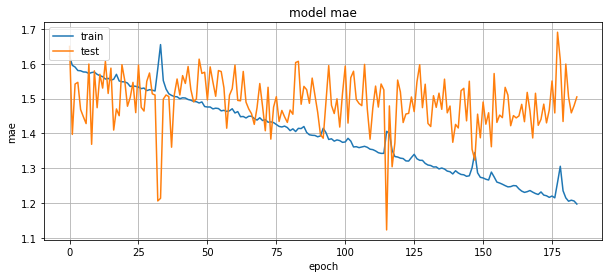

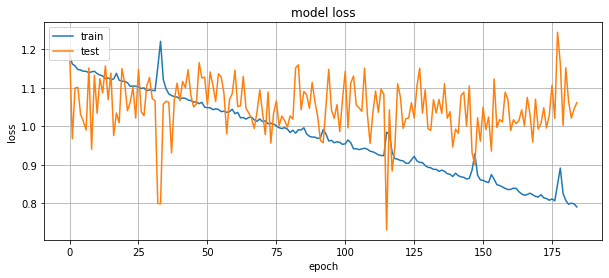

In [92]:
# Creating accuracy plots for CNN models
plt.figure(figsize=(10,4))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()
print()

# Creating loss plots for CNN models
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()